![title](./img/titanic_meme.jpg)

# Explaining model predictions with Shapley values - Random Forest

*Elliot Coyne and Sammi Rosser, HSMA Trainer*

The notebook below is a modified version of the original by Mike Allen's [Titanic Notebooks](https://github.com/MichaelAllen1966/titanic).

Shapley values provide an estimate of how much any particular feature influences the model decision (prediction). When Shapley values are averaged they provide a measure of the overall influence of a feature.

Shapley values may be used across model types, and so provide a *model-agnostic* measure of a feature's influence. This means that the influence of features may be compared across model types, and it allows *black box* models like neural networks to be explained, at least in part.

Here we will demonstrate Shapley values with random forests.

For more on Shapley values in general see Chris Molner's excellent book chapter:

https://christophm.github.io/interpretable-ml-book/shapley.html

The `shap` package is installed if you have used the `ml` environment yaml file, but otherwise may be installed with `pip install shap`.

More information on the `shap` library, inclusiong lots of useful examples may be found at: https://shap.readthedocs.io/en/latest/index.html

Here we provide an example of using `shap` with Random Forests.

Shap values are returned in a slightly different way to logistic regression  - there is a set of Shap values for each classification probablility ('not survive', 'survive') so we need slightly different syntax to access and use the Shap values.

## Load data and fit model

### Load modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Import shap for shapley values
import shap

# JavaScript Important for the interactive charts later on
shap.initjs()

### Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = True

if download_required:

    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./datasets/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [3]:
data = pd.read_csv('datasets/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

### Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [4]:
# Use `survived` field as y, and drop for X
y = data['Survived'] # y = 'survived' column from 'data'
X = data.drop('Survived', axis=1) # X = all 'data' except the 'survived' column

# Drop PassengerId
X.drop('PassengerId',axis=1, inplace=True)

### Divide into training and tets sets

When we test a machine learning model we should always test it on data that has not been used to train the model.
We will use sklearn's `train_test_split` method to randomly split the data: 75% for training, and 25% for testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

### Fit Random Forest model

In [6]:
model = RandomForestClassifier(n_estimators=100,
                               n_jobs=-1,
                               class_weight='balanced',
                               random_state=42,
                               max_depth=7)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_jobs=-1,
                       random_state=42)

### Predict values and get probabilities of survival

Now we can use the trained model to predict survival. We will test the accuracy of both the training and test data sets.

In [7]:
# Predict training and test set labels
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Predict probabilities of survival
y_prob_train = model.predict_proba(X_train)
y_prob_test = model.predict_proba(X_test)

### Calculate accuracy

In this example we will measure accuracy simply as the proportion of passengers where we make the correct prediction. In a later notebook we will look at other measures of accuracy which explore false positives and false negatives in more detail.

In [8]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:.2%}')
print (f'Accuracy of predicting test data = {accuracy_test:.2%}')

Accuracy of predicting training data = 88.92%
Accuracy of predicting test data = 81.17%


## Examining the model importances

As we have used a tree-based model, we can easily pull out the feature importances using the MDI (mean decrease in impurity) approach, which are stored in `model.feature_importances_`.

In [9]:
features = list(X_train)

feature_importances = model.feature_importances_

importances = pd.DataFrame(index=features)
importances['importance'] = feature_importances
importances['rank'] = importances['importance'].rank(ascending=False).values
importances.sort_values('rank').head()

,importance,rank
male,0.348332,1.0
Fare,0.148499,2.0
Age,0.116853,3.0
Pclass,0.074443,4.0
CabinNumber,0.064082,5.0


The three most influential features are:

* *male*
* *Fare*
* *age*

Note: random forest importances do not tell us anything about the direction of effect of features (as with random forests, the direction of effect may depend on the value oif other features).

Note that we could also use _permutation feature importance_ here as an alternative approach. 

This works with tree based models, but is actually a model-agnostic approach. 

In [ ]:
feature_names = X.columns.tolist()

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Get Shapley values

We use the `shap_values` method from the SHAP library to get Shapley values.
We use the `explainer` method from the SHAP library to get Shapley values along with other data.

We pass a sample to the explainer to speed up Shap (which can be slow with random forests - these values are used as expected baseline values for features).

<!-- [`check_additivity`](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html?highlight=check_additivity) has been disabled as the fit reported a small difference between between predicted probability and baseline probability with all Shap values summed. -->

In [263]:
# Get list of features
features = list(X)

# Train explainer on Training set
# explainer = shap.TreeExplainer(model, X_train.sample(100))
explainer = shap.Explainer(model)

# shap_values_train = explainer(X_train, check_additivity=False)
# shap_values_train = shap_values_train_extended.values[:,:,1]

# shap_values_test = explainer(X_test, check_additivity=False)
# shap_values_test = shap_values_test_extended.values[:,:,1]

shap_values = explainer(X)

# Calculate mean Shap value for each feature in training set
#shap_values.values[:,:,1] extracts
importances['mean_shap_values'] = np.mean(shap_values.values[:,:,1], axis=0)

# Calculate mean absolute Shap value for each feature in training set
# This will give us the average importance of each feature
importances['mean_abs_shap_values'] = np.mean(
    np.abs(shap_values.values[:,:,1]),axis=0)

Add Shap values to coefficient table.

In [264]:
importances.sort_values(by='importance', ascending=False).head()
importances.head(10)

,importance,rank,mean_shap_values,mean_abs_shap_values
Pclass,0.074443,4.0,0.000104,0.046244
Age,0.116853,3.0,-0.009909,0.027227
SibSp,0.049939,6.0,-0.000526,0.009984
Parch,0.035535,7.0,-0.000409,0.009245
Fare,0.148499,2.0,-0.007285,0.039548
AgeImputed,0.016543,13.0,-0.000498,0.011292
EmbarkedImputed,0.000063,24.0,-0.000046,0.000049
CabinLetterImputed,0.020252,10.0,-0.001481,0.008860
CabinNumber,0.064082,5.0,-0.007249,0.025738
CabinNumberImputed,0.030591,8.0,-0.002550,0.021284


Get top 10 influential features by co-efficients for SHAP

In [265]:
# Get top 10 features
importance_top_10 = \
    importances.sort_values(by='importance', ascending=False).head(10).index
shapley_top_10 = \
    importances.sort_values(
    by='mean_abs_shap_values', ascending=False).head(10).index

# Add to DataFrame
top_10_features = pd.DataFrame()
top_10_features['importances'] = importance_top_10.values
top_10_features['Shap'] = shapley_top_10.values

# Display
top_10_features

,importances,Shap
0,male,male
1,Fare,Pclass
2,Age,Fare
3,Pclass,Age
4,CabinNumber,CabinNumber
5,SibSp,CabinNumberImputed
6,Parch,Embarked_S
7,CabinNumberImputed,Embarked_C
8,CabinLetter_missing,AgeImputed
9,CabinLetterImputed,CabinLetter_missing


We can see a lot of overlap between the most import fatures as estimated by coefficients and those estimated using mean absolute Shapley values. But they are not identical.

Plot comparison of Shapley and model coefficients:

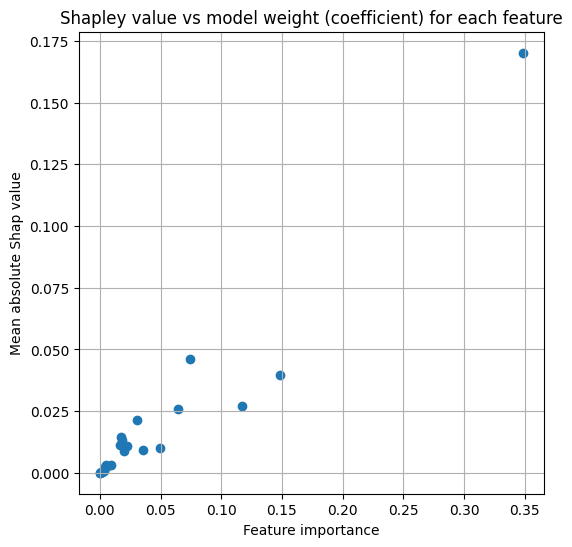

In [266]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# Plot points
x = importances['importance']
y = importances['mean_abs_shap_values']

ax.scatter(x, y)
ax.set_title('Shapley value vs model weight (coefficient) for each feature')
ax.set_ylabel('Mean absolute Shap value')
ax.set_xlabel('Feature importance')

plt.grid()
plt.show()

# Partial Dependence Plots (PDPs) and Individual Conditional Expectation (ICE) Plots



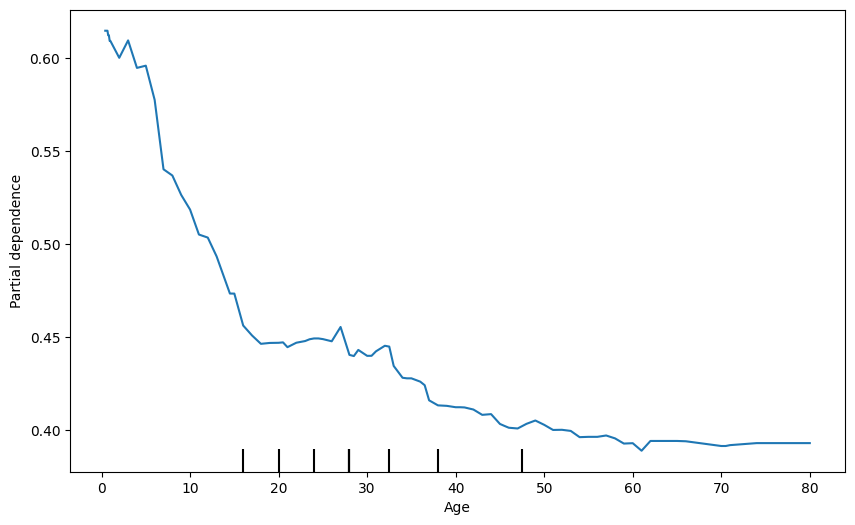

In [277]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=['Age'],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

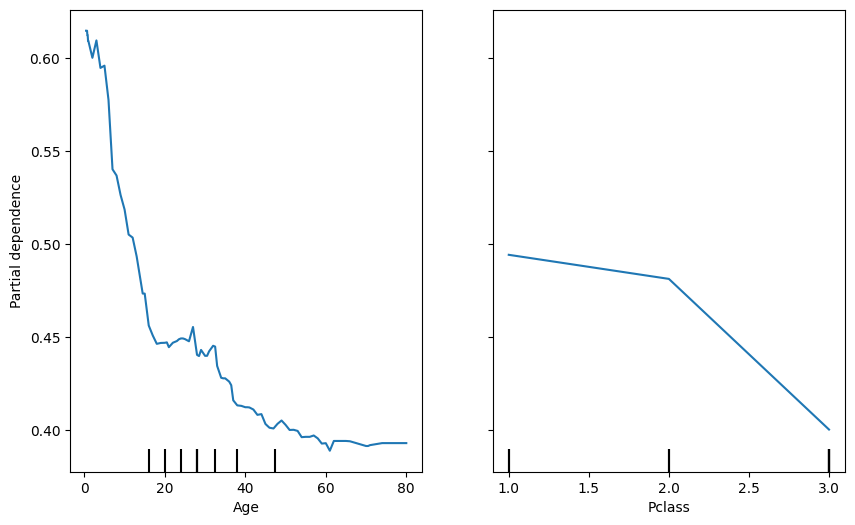

In [270]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=['Age', 'Pclass'],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

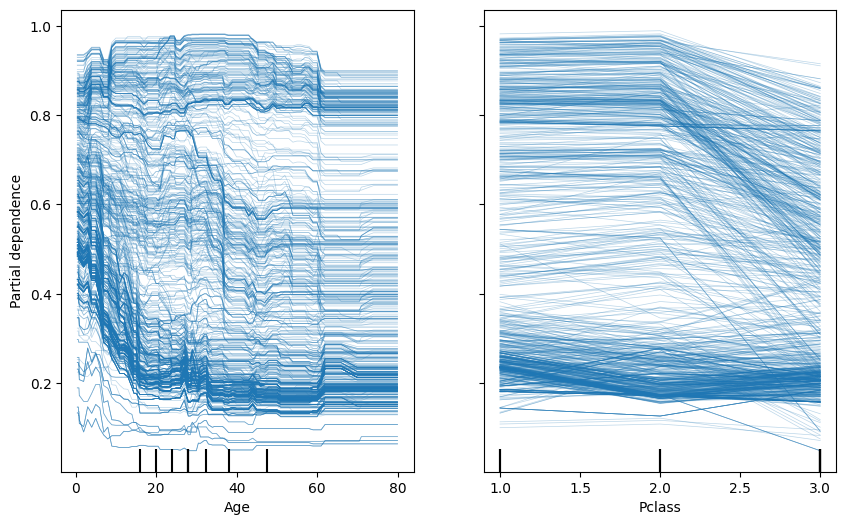

In [271]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=['Age', 'Pclass'],  # List of features to plot
    target=0,
    kind='individual',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

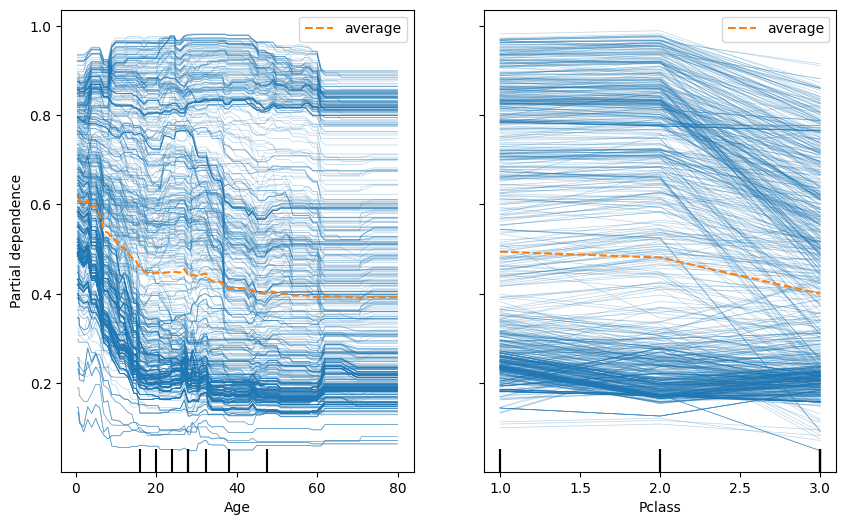

In [272]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=['Age', 'Pclass'],  # List of features to plot
    target=0,
    kind='both',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

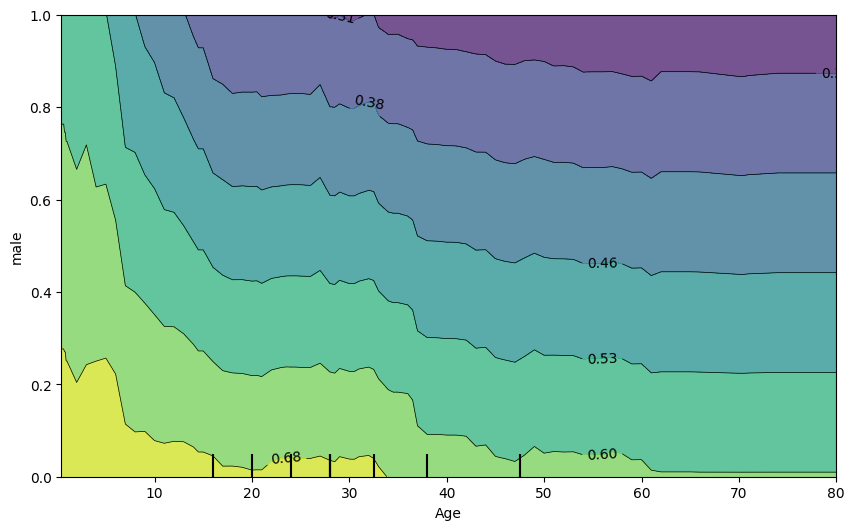

In [280]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=[('Age', 'male')],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

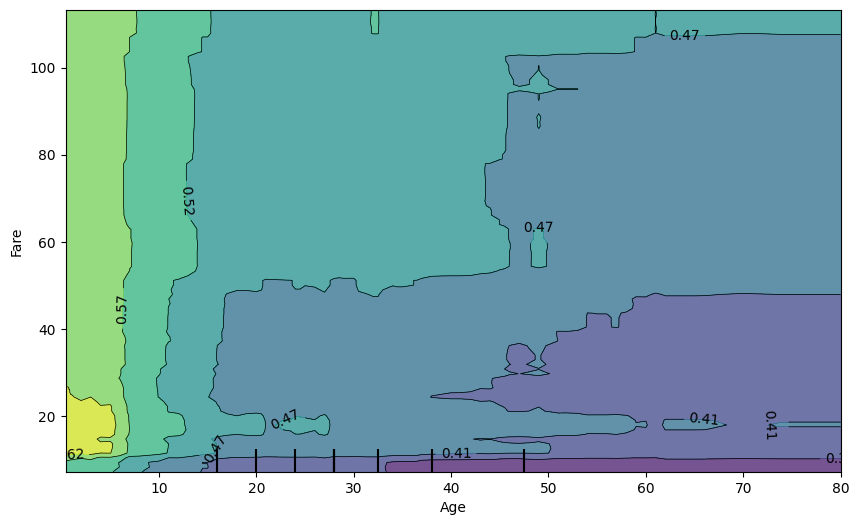

In [281]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=[('Age', 'Fare')],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

## Plots of Shapley values

### [Summary Plot](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html)

The `summary_plot` using a `plot_type` option of `bar` gives us the overall importance of each feature across the population.

Here we limit the num,ber of features shown to 15 (default is 20).

<Figure size 600x600 with 0 Axes>

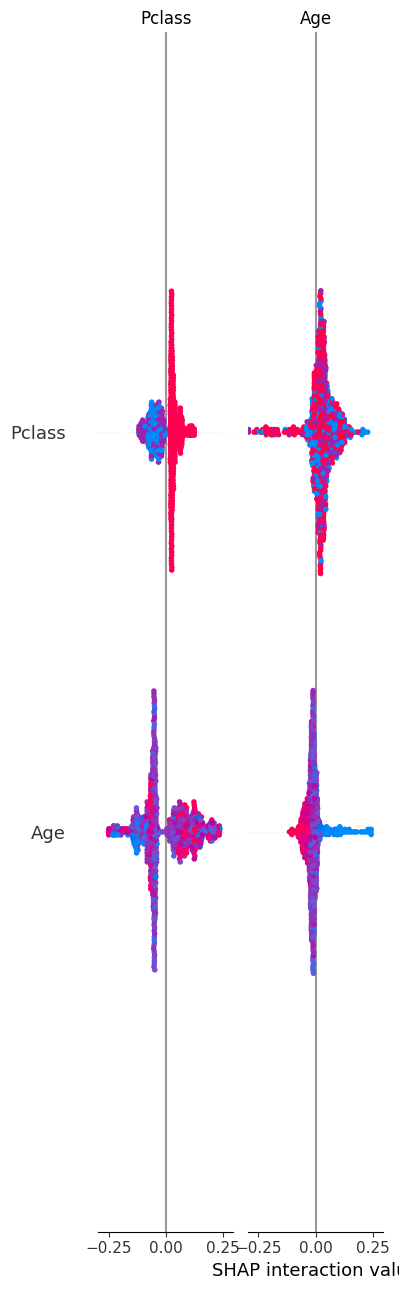

In [168]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shap_values,
                  features = X.values,
                  feature_names = X.columns.values,
                  plot_type='bar',
                  max_display=15,
                  show=False)
plt.tight_layout()
plt.show()

### Summary plots with cohorts

In [85]:
# shap_values.cohorts(sex).abs.mean(axis=0)

<shap._explanation.Cohorts object with 2 cohorts of sizes: [(24, 2), (24, 2)]>

In [92]:
# shap_values_train[1, :]

array([-2.19342675e-02, -1.01826629e-02, -9.93214744e-03, -3.96157764e-03,
       -5.36622050e-02,  9.14737276e-03,  0.00000000e+00,  2.64619972e-03,
       -2.20030909e-02, -1.66399609e-02, -1.61967865e-01, -1.31440693e-02,
        1.24235346e-03, -1.06402788e-02,  0.00000000e+00,  5.26666677e-04,
       -8.72619043e-04,  7.47777772e-04, -1.21747406e-03, -2.29535712e-03,
        7.13201813e-05,  0.00000000e+00,  0.00000000e+00,  4.05148957e-03])

TypeError: 'numpy.float64' object is not iterable

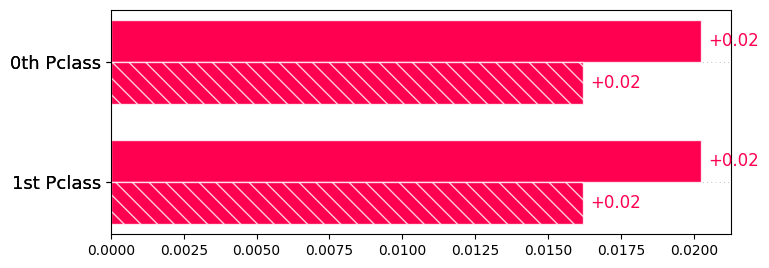

In [170]:
sex = ["Women" if shap_values[i, "male"].data == 1 else "Men" for i in range(shap_values.shape[0])]

# fig = plt.figure(figsize=(6,6))

# shap.summary_plot(shap_values = shap_values_train_extended.cohorts(sex).abs.mean(axis=0),
#                   features = X_train.values,
#                   feature_names = X_train.columns.values,
#                   plot_type='bar',
#                   max_display=15,
#                   show=False)
# plt.tight_layout()
# plt.show()

shap.plots.bar(shap_values.cohorts(sex).abs.mean(axis=0))

In [171]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

ValueError: Found array with dim 3. DecisionTreeRegressor expected <= 2.

### Summary Plot - Beeswarm

Without specifying a `plot_type` option of `bar`, `summary_plot` gives us a *beeswarm* plot, showing the Shapley values for all instances.

<Figure size 600x600 with 0 Axes>

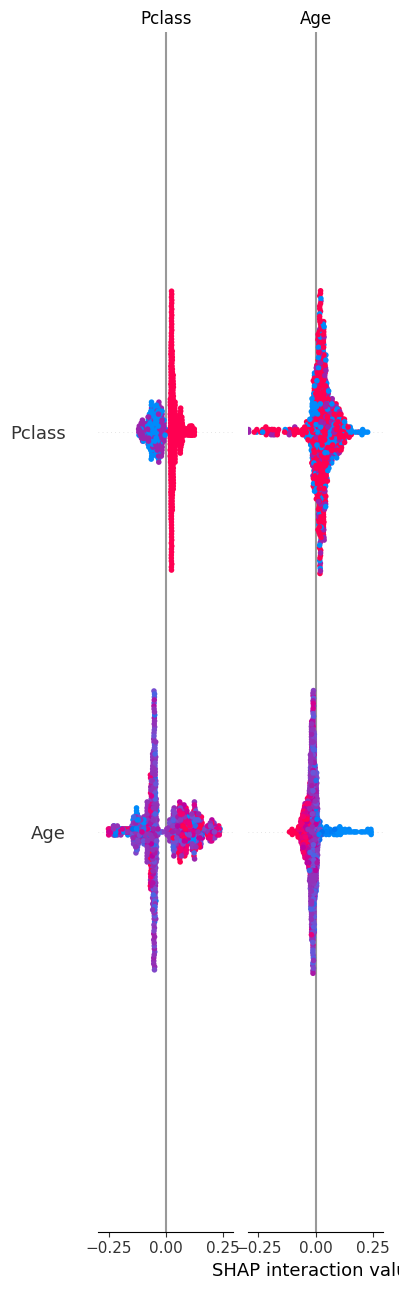

In [172]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shap_values,
                  features = X.values,
                  feature_names = X.columns.values,
                  max_display=15,
                  show=False)
plt.tight_layout()
plt.show()

### [Waterfall Plot](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.waterfall_plot.html?highlight=plots.waterfall)

Waterfall plots show the influence of  individual features on model prediction. These are shown as the effect on [*log odds ratio*](https://www.statisticshowto.com/log-odds/) of survival. *Log odds ratio* are usually shown as these are additive, whereas probabilities are not.

Waterfall plots put the most influential features at the top.

Get locations of passengers with low or high probability of survival.

In [203]:
y_prob = model.predict_proba(X_test)[:, :1]
# # Get the location of an example each where porbability of survival
# # is <0.01 or >0.99

# location_low_probability = np.where(y_prob < 0.05)[0]
# location_high_probability = np.where(y_prob > 0.9)[0]

instance_index = 0  # Choose the instance you want to explain
probabilities = model.predict_proba(X[instance_index:instance_index+1])
lowest_prob_class = probabilities.argmin()

Waterfall plot for passenger with lowest probability of survival:

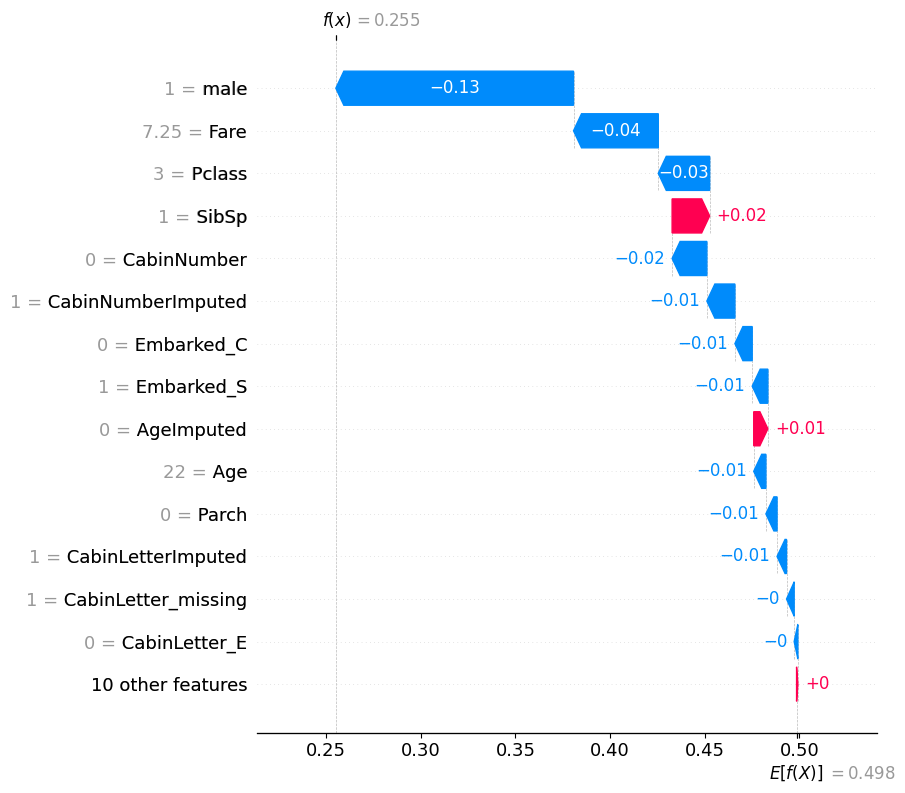

In [218]:
# shap.plots.waterfall(shap_values[location_low_probability][:,1],
#                      max_display=15)
shap.plots.waterfall(shap_values[instance_index, :, lowest_prob_class], max_display=15)

Waterfall plot for passenger with high probability of survival:

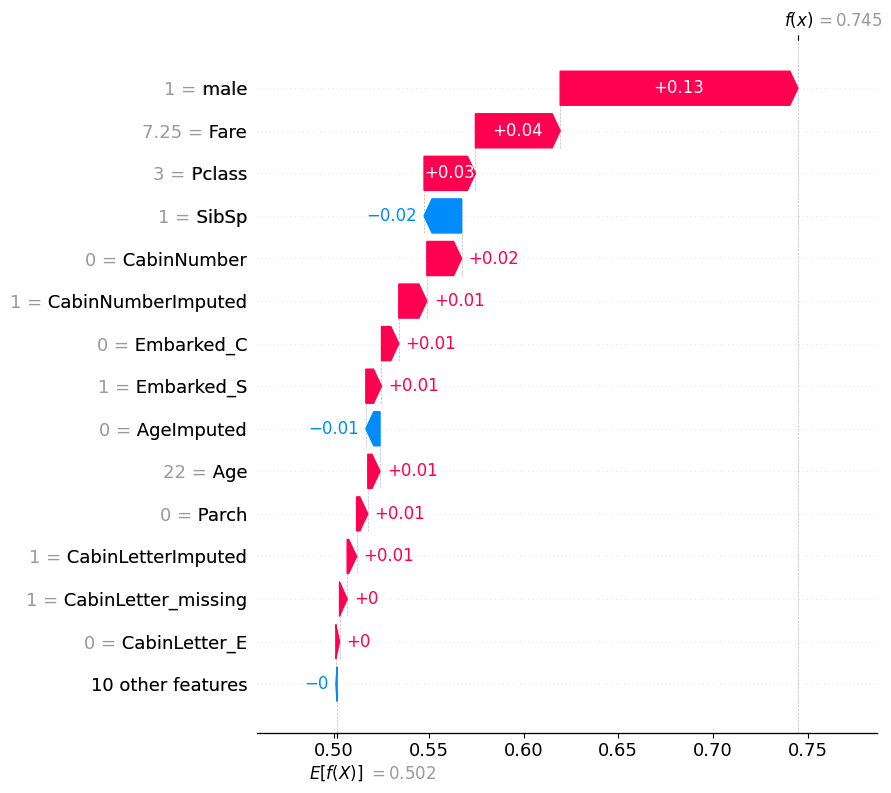

In [205]:
highest_prob_class = probabilities.argmax()

# shap.plots.waterfall(shap_values[location_high_probability][:,1],
#                      max_display=15)

shap.plots.waterfall(shap_values[instance_index, :, highest_prob_class], max_display=15)

### [Scatter Plot](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/plots/scatter.html)
a.k.a. Dependence Plot

A scattter plot for one or more features shows the relationship between the feature value and the Shap value, along with a histogram of the frequency of the feature values.

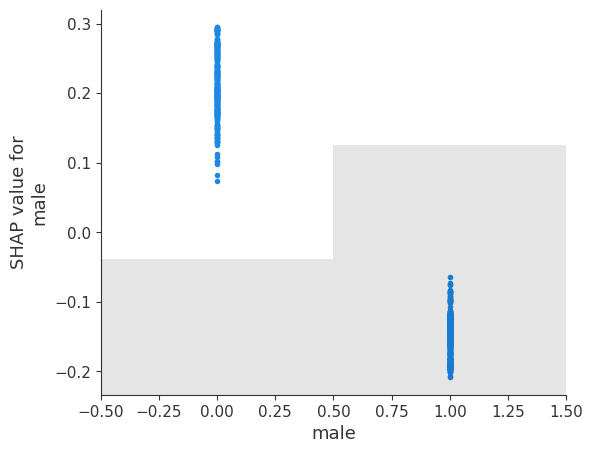

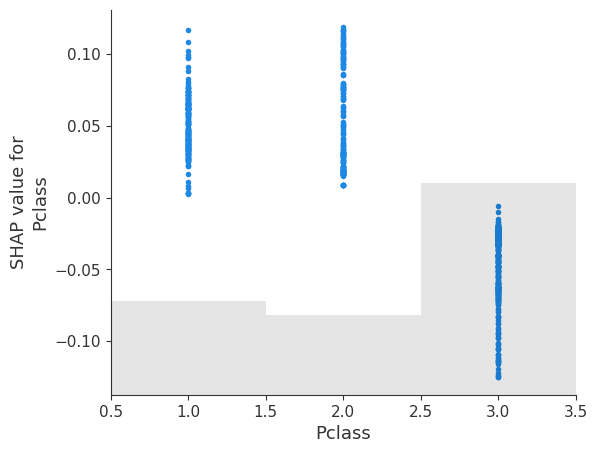

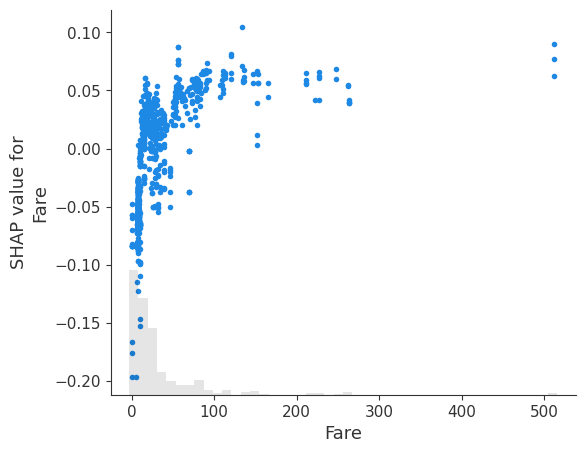

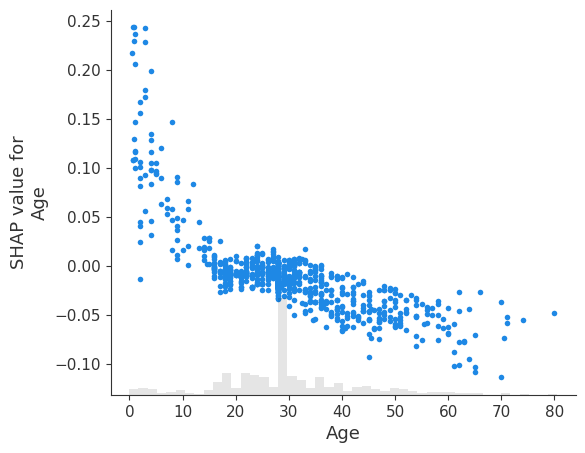

In [207]:
feat_to_show = shapley_top_10[0:4]

for feat in feat_to_show:
    shap.plots.scatter(shap_values[:, feat][:,1],
                       x_jitter=0)

Note: unlike a logistic regression model, Shap values are not linearly releated to feature values. This is because of the more flexible classification method in random forests.

### Colouring dependence (scatter) plots by strongly interacting features

If we just pass in the shap_values object, then each plot will be highlighted by the most strongly interacting variable.

In [242]:
shap_values

.values =
array([-6.43529797e-03, -1.04856679e-02,  3.73775798e-03, -3.03513904e-03,
       -3.67397085e-02, -1.06393868e-02, -8.23218091e-02,  1.55703027e-01,
       -2.21907679e-03,  2.85878009e-02,  3.15079074e-02, -5.04521757e-02,
       -7.44513630e-03, -5.57447253e-02,  1.66012435e-02, -3.89966201e-02,
        8.08526908e-02, -2.01460928e-02, -5.37486345e-04, -7.67460174e-03,
       -2.75305601e-02, -5.90961733e-03,  2.54931229e-02, -2.72471952e-02,
        1.55049885e-02, -5.11158213e-02, -2.32403357e-02, -3.19283221e-03,
        2.65437861e-03, -1.72297483e-02, -2.92155093e-02,  4.64244376e-04,
        2.41534695e-03, -2.69493139e-02, -3.04060889e-02, -2.86712543e-02,
       -2.17647553e-02, -1.12711819e-02, -1.11406992e-02,  1.62038386e-02,
       -6.66448365e-02, -1.14949271e-02, -2.15338908e-02,  9.27189617e-02,
       -1.05644303e-02, -1.76988128e-02, -1.74322163e-02,  2.41534695e-03,
       -2.64980396e-02, -8.75151361e-03,  6.76225230e-02, -9.68713588e-03,
       -2.30263

In [253]:

shap.plots.scatter(shap_values[:, "Age"][:,1],
                    x_jitter=0,
                    color=shap_values[:, :][:,0][:,1]
                    )

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 891 and the array at index 1 has size 1782

Or we can choose to pass in a single column.

In [123]:
feat_to_show

Index(['male', 'Age', 'Fare', 'Pclass'], dtype='object')

In [220]:
shap_values[:, 'male']

.values =
array([[ 0.12552706, -0.12552706],
       [-0.19106188,  0.19106188],
       [-0.22862218,  0.22862218],
       ...,
       [-0.17310668,  0.17310668],
       [ 0.1413449 , -0.1413449 ],
       [ 0.15861914, -0.15861914]])

.base_values =
array([[0.50153858, 0.49846142],
       [0.50153858, 0.49846142],
       [0.50153858, 0.49846142],
       ...,
       [0.50153858, 0.49846142],
       [0.50153858, 0.49846142],
       [0.50153858, 0.49846142]])

.data =
array([1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
      

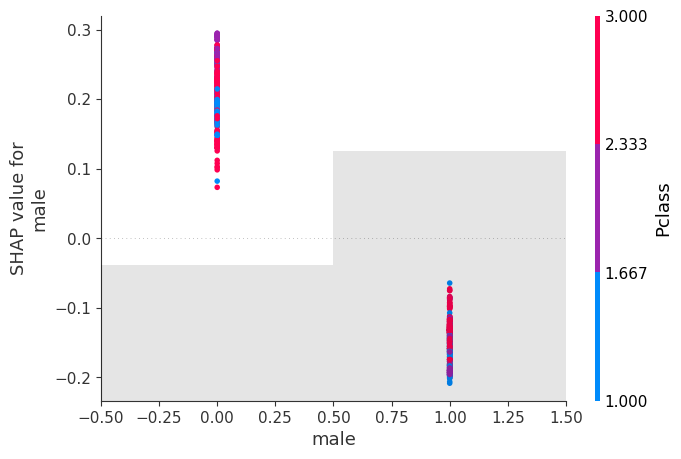

In [229]:
shap.plots.scatter(shap_values[:, 'male'][:,1],
                    x_jitter=0,
                    color=shap_values[:, 'Pclass'][:,1]
                    )

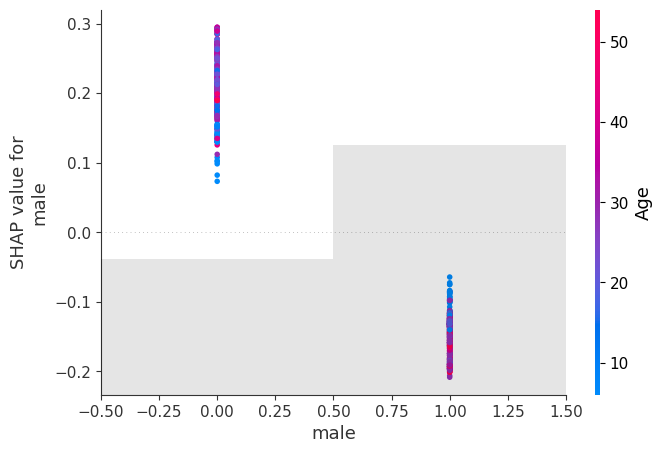

In [230]:
shap.plots.scatter(shap_values[:, 'male'][:,1],
                    x_jitter=0,
                    color=shap_values[:, 'Age'][:,1]
                    )

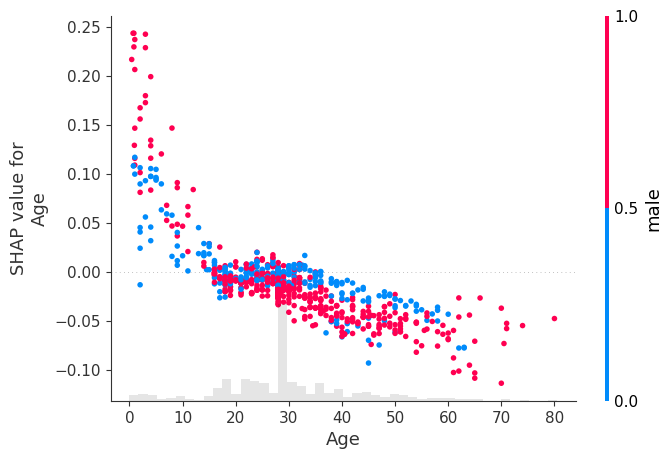

In [231]:
shap.plots.scatter(shap_values[:, 'Age'][:,1],
                    x_jitter=0,
                    color=shap_values[:, 'male'][:,1]
                    )

## Highly correlated variables

In [216]:
clustering = shap.utils.hclust(X, y)
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.5)

ValueError: Found input variables with inconsistent numbers of samples: [891, 24]